# Deep Learning Final Project

In [4]:
import gc
import os,h5py
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from model import resnet
import torch
from torch import nn,optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [5]:
EXAMPLE_DATA_ROOT_FOLDER = 'data/'

In [6]:
class TextureDataset(Dataset):
    filenames = {64: dict(train=('train64.csv', 'train64.h5'), test=('test64.csv', 'test64.h5')),
                 32: dict(train=('train32.csv', 'train32.h5'), test=('test32.csv','test32.h5'))}
    indication_classes = ['index', 'angle', 'indication_type', 'indication_value', 'split']
    def __init__(self,root_folder, train=True, patch_size=64, classification=True, task='defect',keep_angles=True,keep_defects=False, transformation=None, test_sub_sample=200):
        if os.path.exists(root_folder):
            self.root_folder = root_folder
        else:
            raise IOError('The path of the directory is incorrect or doesn\'t exist')
        
        self.patch_size = patch_size if patch_size in self.filenames.keys() else 32
        self.infos, self.data = self.load_data(train)
        if train:
            if classification:
                print('Classification Task:', end=' ')
                if task=='defect' and not keep_angles:    
                    self.infos = self.infos.loc[self.infos['angle']==0]
                    print('Drop all angles others than 0')
                elif task=='angle' and not keep_defects:
                    self.infos = self.infos.loc[self.infos['indication_type']=='good']
                    print('Drop all defect (all other than good)')
                else:
                    print('Keepíng all the data')
                    pass
            else:
                print('By default only keep healthy')
                self.infos = self.infos.loc[(self.infos['indication_type']=='good') & (self.infos['angle']==0)]
            self.data = self.data[self.infos.index]
        self.transformation = transforms.Compose([transforms.ToTensor()]) if transformation is None  else  transformation
        
        
        if not train and test_sub_sample:
            X = []
            newinfo = pd.DataFrame()
            for (a,t), df in self.infos.groupby(['angle','indication_type']):
                index = df.index
                subi = np.random.choice(index, test_sub_sample, replace=False)
                X.append(self.data[subi])
                newinfo = newinfo.append(self.infos.iloc[subi],ignore_index=True)
            self.infos = newinfo
            self.data = np.concatenate(X)
    
    def __len__(self):
        return self.infos.shape[0]
        
    def __getitem__(self,index):
        info = self.infos.iloc[index]
        angle, indication_value = int(info['angle'])//20, int(info['indication_value'])
        img = self.data[index]
        
        return self.transformation(img),angle, indication_value
            
    
    def load_data(self,train):
        files = self.filenames[self.patch_size]
        infos_filename, data_filename = files['train'] if train else files['test']
        
        infos = pd.read_csv(os.path.join(self.root_folder,infos_filename))
        data = None
        with h5py.File(os.path.join(self.root_folder,data_filename),mode='r') as h5file:
            data = h5file['images'][:]
        return infos, data        
    
    @staticmethod
    def get_angles_classes():
        return np.arange(8)* 20
    @staticmethod
    def get_indication_classes():
        return ['good', 'color', 'cut',  'hole', 'thread', 'metal_contamination']
    @staticmethod
    def compute_normalization_parameters(root):
        print('#### Compute Mean and Std of image for image scaling')
        dataset = TextureDataset(root_folder=root, classification=True,task='angle',keep_defects=False)
        loader = DataLoader(dataset,batch_size=15, num_workers=4, shuffle=True)
        mean = 0.
        std = 0.
        for images, _,_ in loader:
            batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        mean /= len(loader.dataset)
        std /= len(loader.dataset)
        print(f""" Normalize the data as following:
        transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize({mean}, {std} )])
        this function return the object Normalize the new mean and std: transforms.Normalize({mean}, {std} )
        """)
        return transforms.Normalize(mean, std )

In [7]:
def example():
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    
    dataset = TextureDataset(EXAMPLE_DATA_ROOT_FOLDER,classification=True,task='defect',transformation=transformation)
    loader = DataLoader(dataset=dataset,batch_size=64, shuffle=True)
    for data in loader:
        img, angle_value, indication_value = data
        grid_img = make_grid(img,nrow=8).permute(1, 2, 0)
        plt.figure()
        plt.imshow(grid_img)
        plt.axis('off')
        break

In [ ]:
example()
TextureDataset.compute_normalization_parameters(root=EXAMPLE_DATA_ROOT_FOLDER)

In [8]:
class Trainer(object):
    def __init__(self, model,  optimizer, criterion,  train_loader, val_loader,no_epochs=5, device='cpu',target_type='defect',lr=1e-1, *args,**kwargs):
        
        assert target_type in ['angle','defect']
        self.no_epochs = no_epochs
        self.target_type = target_type
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer(self.model.parameters(),lr=lr) 
        
        self.train_loader, self.valid_loader = train_loader, val_loader
        print("Total_params",sum(p.numel() for p in model.parameters()))
        print("Trainable_params",sum(p.numel() for p in model.parameters() if p.requires_grad))
        self.device = device
        

    def train_an_epoch(self):
        self.model.train()
        train_loss = 0.0
        for data in tqdm(self.train_loader):
            
            if self.target_type =='angle':
                data, target, _ = data
            else:
                data, _, target = data
            data, target = data.to(self.device), target.to(self.device)
            # clear the gradients of all optimized variables
            self.optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)
            # calculate the batch loss
            loss = self.criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            self.optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
        return train_loss
        
    def valid_an_epoch(self):
        valid_loss = 0.0
        self.model.eval()
        
        OUTPUT = []
        TARGET = []
        for data in tqdm(self.valid_loader):
            if self.target_type =='angle':
                data, target, _ = data
            else:
                data, _, target = data
            data, target = data.to(self.device), target.to(self.device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)
            # calculate the batch loss
            loss = self.criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)            
            # converting raw _logits to softmax output
            output = nn.functional.softmax(output,dim=-1).detach().cpu().numpy()
            OUTPUT.append(np.argmax(output, axis=-1))
            TARGET.append(target.detach().cpu().numpy())
        return valid_loss, self.accuracy_per_class(np.concatenate(OUTPUT),np.concatenate(TARGET))
    
    def accuracy_per_class(self,ouput,target):
        matrix = confusion_matrix(target, ouput)
        return matrix.diagonal()/matrix.sum(axis=1)
    
    def train(self):
        accuracy = []
        alltrainloss = []
        allvalidloss = []
        for epoch in range(1, self.no_epochs+1):

            train_loss = self.train_an_epoch()
            valid_loss, accuracy_perclass = self.valid_an_epoch()
            train_loss = train_loss/len(self.train_loader.sampler)
            valid_loss = valid_loss/len(self.valid_loader.sampler)
            gc.collect()
            
            alltrainloss.append(train_loss)
            allvalidloss.append(valid_loss)
            accuracy.append(accuracy_perclass.reshape(1,-1))
            # print training/validation statistics 
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        figure,axes = plt.subplots(1,2,figsize=(10,8))
        ax1,ax2= axes.ravel()
        linet, = ax1.plot(alltrainloss,label='Train')
        linev, = ax1.plot(allvalidloss,label='Valid')
        ax1.legend([linet,linev],['train','valid'])
        labels = TextureDataset.get_indication_classes() if self.target_type=='defect' else TextureDataset.get_angles_classes()
        lines = []
        for i, c in  zip(labels, np.concatenate(accuracy).T):
            line, = ax2.plot(c, label=i)
            lines.append(line)
        ax2.legend(lines,labels)
        print(accuracy)

In [9]:


class CNN(nn.Module):
    def __init__(self, nclasses, in_channel=1,*args,**kwargs):
        super(CNN, self).__init__()
        print(nclasses)
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.BatchNorm2d(32),nn.ReLU(),
                                     nn.AvgPool2d(2),
                                     nn.Conv2d(32, 64, kernel_size=3),nn.BatchNorm2d(64),nn.ReLU(),
                                     nn.AvgPool2d(2),
                                     nn.Conv2d(64, 32, kernel_size=1),
                                     nn.AdaptiveAvgPool2d(1))
        self.l = nn.Linear(32, nclasses)
        
    def forward(self, x):
        x = self.encoder(x)
        x= x.view(x.shape[0],-1)
        return self.l(x)

In [10]:
def getdataloader(root, patch_size=64, task='defect',batch_size=32,keep_angles=False,test_sub_sample=False,num_workers=0, *args,**kwargs):
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352]), transforms.RandomErasing(0.3, value=0)])
    dataset = TextureDataset(root,train=True, classification=True, task=task, transformation=transformation,keep_angles=keep_angles)
    train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=True)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    dataset = TextureDataset(root,train=False, classification=True, task=task, transformation=transformation,test_sub_sample=test_sub_sample)
    val_loader = DataLoader(dataset=dataset,batch_size=int(batch_size*2),shuffle=False,num_workers=num_workers)
    return train_loader, val_loader
    
def get_model(modeltype='cnn',  nclasses=6, no_of_channels=1,*args,**kwargs):
    if modeltype =='resnet18': model = resnet.resnet18(in_channels=no_of_channels, n_classes=nclasses)
    elif modeltype =='resnet34': model = resnet.resnet34(in_channels=no_of_channels, n_classes=nclasses)
    elif modeltype =='resnet50': model = resnet.resnet50(in_channels=no_of_channels, n_classes=nclasses)
    elif modeltype =='resnet101': model = resnet.resnet101(in_channels=no_of_channels, n_classes=nclasses)
    elif modeltype =='resnet152': model = resnet.resnet152(in_channels=no_of_channels, n_classes=nclasses)
    else:model = CNN(nclasses=nclasses, in_channel=no_of_channels)
    return model
        
    
def run(options):
    train_loader, val_loader = getdataloader(**options)        
    model = get_model(**options)
    summary(model, (1,options['patch_size'],options['patch_size']),1,'cpu')
    trainer = Trainer(model=model, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss(),  train_loader=train_loader, val_loader=val_loader, **options)
    trainer.train()
    gc.collect()

Classification Task: Keepíng all the data
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 16, 16]           3,136
       BatchNorm2d-2            [1, 64, 16, 16]             128
              ReLU-3            [1, 64, 16, 16]               0
         MaxPool2d-4              [1, 64, 8, 8]               0
        Conv2dAuto-5              [1, 64, 8, 8]          36,864
       BatchNorm2d-6              [1, 64, 8, 8]             128
              ReLU-7              [1, 64, 8, 8]               0
        Conv2dAuto-8              [1, 64, 8, 8]          36,864
       BatchNorm2d-9              [1, 64, 8, 8]             128
 ResNetBasicBlock-10              [1, 64, 8, 8]               0
       Conv2dAuto-11              [1, 64, 8, 8]          36,864
      BatchNorm2d-12              [1, 64, 8, 8]             128
             ReLU-13              [1, 64, 8, 8]              

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.195581 	Validation Loss: 1511.000488


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.286308 	Validation Loss: 26.913142
[array([[0.   , 0.135, 0.   , 0.   , 0.995, 0.   ]]), array([[0.11    , 0.      , 0.      , 0.      , 0.981875, 0.      ]])]


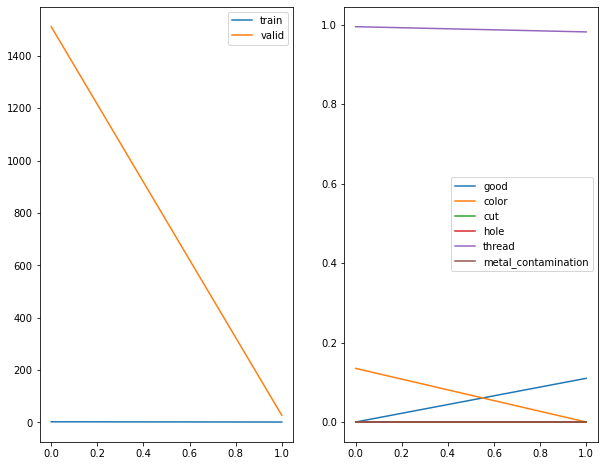

In [30]:
parameter_dict=dict(root='data/', patch_size=32, batch_size=4000, task='defect', nclasses = len(TextureDataset.get_indication_classes()), 
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=5e-3, no_epochs=2, keep_angles=True, test_sub_sample=200,num_workers=0, modeltype='resnet18')
run(parameter_dict)


Classification Task: Keepíng all the data
6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 30, 30]             320
       BatchNorm2d-2            [1, 32, 30, 30]              64
              ReLU-3            [1, 32, 30, 30]               0
         AvgPool2d-4            [1, 32, 15, 15]               0
            Conv2d-5            [1, 64, 13, 13]          18,496
       BatchNorm2d-6            [1, 64, 13, 13]             128
              ReLU-7            [1, 64, 13, 13]               0
         AvgPool2d-8              [1, 64, 6, 6]               0
            Conv2d-9              [1, 32, 6, 6]           2,080
AdaptiveAvgPool2d-10              [1, 32, 1, 1]               0
           Linear-11                     [1, 6]             198
Total params: 21,286
Trainable params: 21,286
Non-trainable params: 0
-----------------------------------------------------

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.478369 	Validation Loss: 1.461997


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.303765 	Validation Loss: 1.333867
[array([[0.141875, 0.940625, 0.01625 , 0.00125 , 0.75    , 0.0425  ]]), array([[0.      , 0.826875, 0.00375 , 0.581875, 0.544375, 0.77    ]])]


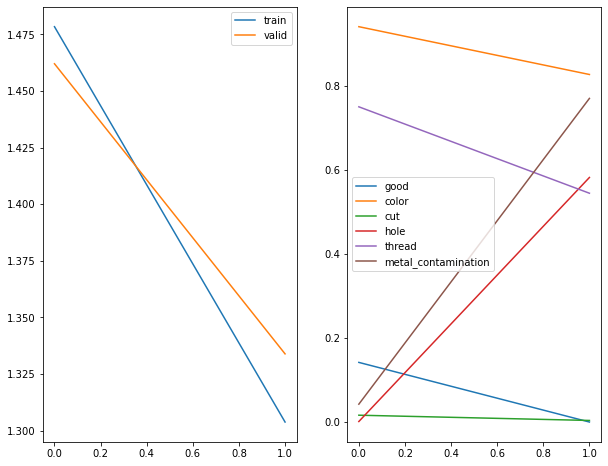

In [31]:
parameter_dict=dict(root='data/', patch_size=32, batch_size=4000, task='defect', nclasses = len(TextureDataset.get_indication_classes()), 
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=5e-3, no_epochs=2, keep_angles=True, test_sub_sample=200,num_workers=0, modeltype='cnn')
run(parameter_dict)


In [11]:
TextureDataset.get_indication_classes()

['good', 'color', 'cut', 'hole', 'thread', 'metal_contamination']

In [ ]:
parameter_dict=dict(root='data/', patch_size=32, batch_size=4000, task='defect', nclasses = len(TextureDataset.get_indication_classes()), 
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=5e-3, no_epochs=2, keep_angles=True, test_sub_sample=200,num_workers=0, modeltype='resnet152')
run(parameter_dict)


Classification Task: Keepíng all the data
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 16, 16]           3,136
       BatchNorm2d-2            [1, 64, 16, 16]             128
              ReLU-3            [1, 64, 16, 16]               0
         MaxPool2d-4              [1, 64, 8, 8]               0
            Conv2d-5             [1, 256, 8, 8]          16,384
       BatchNorm2d-6             [1, 256, 8, 8]             512
        Conv2dAuto-7              [1, 64, 8, 8]           4,096
       BatchNorm2d-8              [1, 64, 8, 8]             128
              ReLU-9              [1, 64, 8, 8]               0
       Conv2dAuto-10              [1, 64, 8, 8]          36,864
      BatchNorm2d-11              [1, 64, 8, 8]             128
             ReLU-12              [1, 64, 8, 8]               0
       Conv2dAuto-13             [1, 256, 8, 8]          16,3

  0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
df = pd.read_csv("data/train32.csv")

In [22]:
df.indication_type.value_counts()

cut                    8000
metal_contamination    8000
hole                   8000
color                  8000
thread                 8000
good                   8000
Name: indication_type, dtype: int64